## Do not edit, just constants and useful function definition 

In [1]:

import oommfc as oc
import discretisedfield as df
import micromagneticmodel as mm
import micromagneticdata as md
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import matplotlib.colors as colors

# Conversion factors
Oe = 1000/(4*np.pi)     # conversion Oe->A/m 79.577471/ 1 mT->10 Oe

# magnetic parametes
alpha_YIG = 1.75e-4    # Gilbert damping (-)

Ms_YIG = 140.7e3           # Saturation magnetisation (A/m). 

A_YIG = 4.22e-12           # Exchange stiffness (J/m)

l_ex = (2*A_YIG/(mm.consts.mu0*Ms_YIG**2)) # Exchange length (m)
# Geometry [m]
l = 60e-6
w = 500e-9
t = 50e-9


# self absorbing boundary condition
band = 1e-6

sourceWidth=600e-9 #cercare bene la misura sul righello
sourcePos=-l/4 #almeno iniettiamo le waves nel bulk, possiamo modificare


# Mesh cell [m]
cx = 10e-9   #50e-9
cy = w  #50e-9
cz = t

cell = (cx, cy, cz)

# Zeeman field
Hx = 0 * Oe # 550 Oe = 55mT as in the paper
Hy = 0
Hz = 0
H_DC = (Hx, Hy, Hz)

transverseFieldSize=0.5e-6

# Amplitude of RF exiting field
H_RF_val = 10 * Oe

# Initial magnetization
m0 = (1, 0, 0)   # Initial reduced magnetization


## Edit from here on

In [2]:

P=1
T = 100e-9 #100e-9
f_MAX = 4e9 

sysName=f"P{P}_{int(T*1e9)}ns_{int(f_MAX*1e-9)}GHz"
f_Nyquist = 2*f_MAX
n_Nyquist = T*f_Nyquist
n_oversampling = 50
sampling = int(n_Nyquist+n_oversampling)


In [3]:
#don't edit this
def plotDispersion(m_fft,xbounds,ybounds,dim):
    #mx
    plt.figure(figsize=(10, 10))

    extent = [-1/cx, 1/cx, -f_MAX, f_MAX]  # extent of k values and frequencies
    plt.imshow(np.log(np.abs(m_fft)**2), extent=extent,
           aspect='auto', origin='lower', norm=colors.CenteredNorm(vcenter=22), cmap="inferno")
    plt.ylabel("$f$ (Hz)")
    plt.xlabel("$kx$ (1/m)")
    plt.xlim(xbounds)
    plt.ylim(ybounds)
    if dim=="x":
        plt.title('F(mx)')
    elif dim=="y":
        plt.title('F(my)')
    if dim=="z":
        plt.title('F(mz)')

def getTimeEvol(dataSet, pos, dim):
    #note: pos must be a tuple (x,y,z)
    if dim=="x":
        mdim=0
    elif dim=="y":
        mdim=1
    elif dim=="z":
        mdim=2
    pos=[round(i) for i in pos]
    xpos,ypos,zpos=pos
    time=dataSet.table.data["t"].values
    dataSet=dataSet.to_xarray()
    m=dataSet[:, xpos, ypos, zpos, mdim]

    m=[i-m[0] for i in m]
    plt.figure()
    plt.title(fr'$\hat m_{dim}(t)$')
    plt.plot(time,m)
    plt.xlabel('t (ns)')
    plt.ylabel('m average')
    plt.legend(['mx'])
    plt.show()
    amp=np.abs(np.fft.fft(m))**2
    f_axis=np.fft.fftfreq(sampling,d=T/sampling)
    plt.plot(f_axis[0:round(sampling/2)]/1e9, amp[0:round(sampling/2)])

def getSpaceEvol(dataSet,start,stop,dim, timestep=sampling-1):
    if dim=="x":
        mdim=0
    elif dim=="y":
        mdim=1
    elif dim=="z":
        mdim=2
    numCells=round((-start+stop)/cx)
    space= np.linspace(start-l/2,stop-l/2,numCells)
    start=round(start/cx)
    stop=round(stop/cx)
    dataSet=dataSet.to_xarray()
    m0=dataSet[0,start,round(w/2/cy), 0,mdim]
    value=dataSet[timestep, start:stop, round(w/2/cy), 0,mdim]
    value=[i-m0 for i in value]
    plt.figure()
    plt.title(f'$\hat m_{dim}(x)$')
    plt.plot(space,value)
    plt.xlabel('x')
    plt.ylabel(f'm{dim} average')
    plt.legend([f'm{dim}'])
    plt.show()
    amp=np.abs(np.fft.fft(value))**2
    f_axis=np.fft.fftfreq(numCells,d=cx)
    plt.plot(f_axis/1e9, amp)   

In [4]:
equilibriumStateData=md.Data(sysName)[0] 
timeSimData=md.Data(sysName)[-1]
print(equilibriumStateData)
print(timeSimData)

OOMMFDrive(name='P1_100ns_4GHz', number=0, dirname='./', x='iteration')
OOMMFDrive(name='P1_100ns_4GHz', number=1, dirname='./', x='t')


### System State before injection

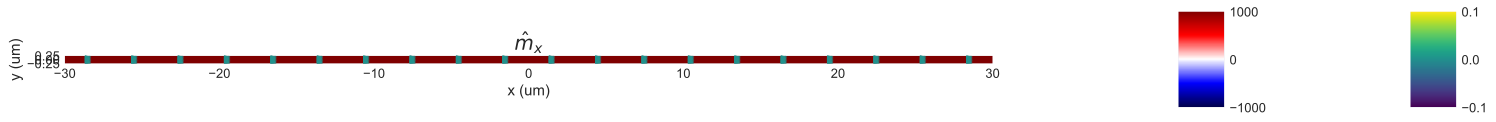

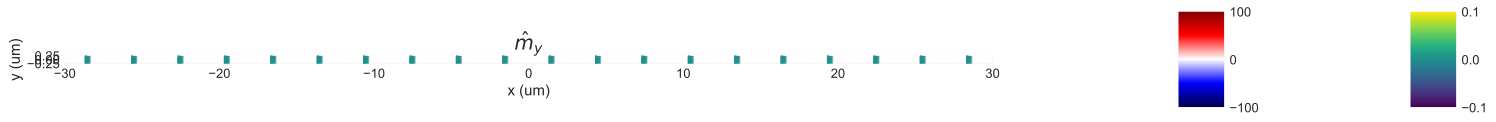

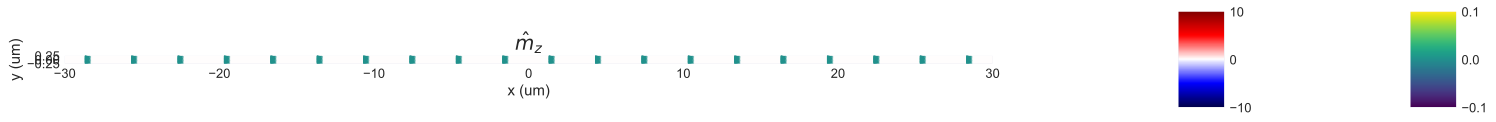

In [5]:

fig,ax =plt.subplots(figsize=(25,10))

plt.title('$\hat m_x$')
equilibriumStateData[-1].x.sel('z').mpl.scalar(ax=ax,vmin=-1000,vmax=1000,cmap='seismic')
equilibriumStateData[-1].sel('z').resample((20,10)).mpl.vector(ax=ax,headwidth=3,scale=2e7)

fig,ax =plt.subplots(figsize=(25,10))
plt.title('$\hat m_y$')
equilibriumStateData[-1].y.sel('z').mpl.scalar(ax=ax,vmin=-100,vmax=100,cmap='seismic')
equilibriumStateData[-1].sel('z').resample((20,10)).mpl.vector(ax=ax,headwidth=3,scale=2e7)

fig,ax =plt.subplots(figsize=(25,10))
plt.title('$\hat m_z$')
equilibriumStateData[-1].z.sel('z').mpl.scalar(ax=ax,vmin=-10,vmax=10,cmap='seismic')
equilibriumStateData[-1].sel('z').resample((20,10)).mpl.vector(ax=ax,headwidth=3,scale=2e7)

plt.show()

### Dispersions
full sample:
-start=band
-stop=l-band

right side:
-start=band
-stop=l/2-transverseFieldSize/2

center:
-start=l/2-transverseFieldSize/2
-stop=l/2+transverseFieldSize/2

left side:
-start=l-band
-stop=l/2+transverseFieldSize/2

In [6]:
data= np.array(timeSimData.to_xarray())

start=band
stop=l/2 - transverseFieldSize/2 

mx = data[:, round(start/cx):round(stop/cx), 0, 0, 0]
my = data[:, round(start/cx):round(stop/cx), 0, 0, 1]
mz = data[:, round(start/cx):round(stop/cx), 0, 0, 2]

In [8]:
# questo non ho ben capito a cosa serva, nel senso che Ax è letteralmente uguale a mx, almeno nei miei test
Ax = np.reshape(mx, (-1, round(stop/cx-start/cx)))
Ax = np.fliplr(Ax)
# 2d perchè ci serve lungo il primo asse (tempo) e lungo il secondo (spazio)
m_fft_x = np.fft.fft2(Ax)
m_fft_x = np.fft.fftshift(m_fft_x)  # questo centra le frequenze

Ay = np.reshape(my, (-1, round(stop/cx-start/cx)))
Ay = np.fliplr(Ay)
m_fft_y = np.fft.fft2(Ay)
m_fft_y = np.fft.fftshift(m_fft_y)

Az = np.reshape(mz, (-1, round(stop/cx-start/cx)))
Az = np.fliplr(Az)
m_fft_z = np.fft.fft2(Az)
m_fft_z = np.fft.fftshift(m_fft_z)

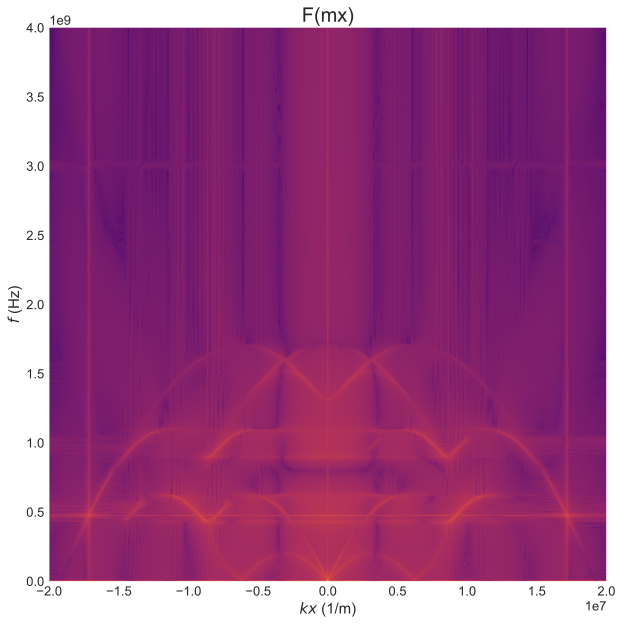

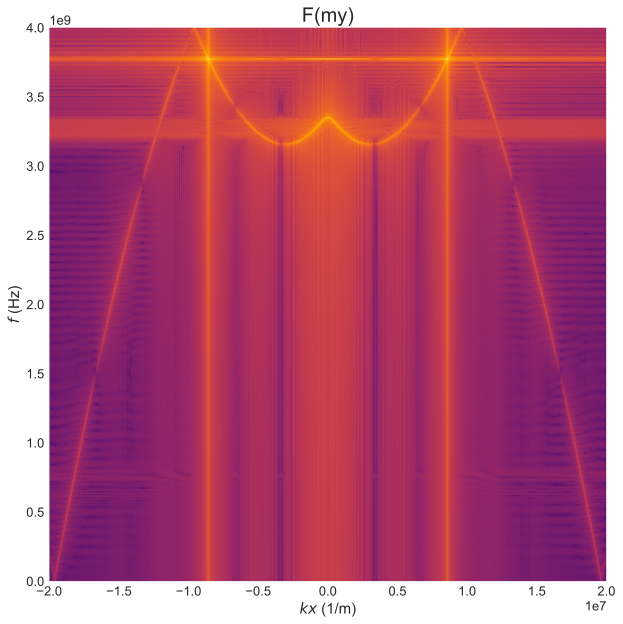

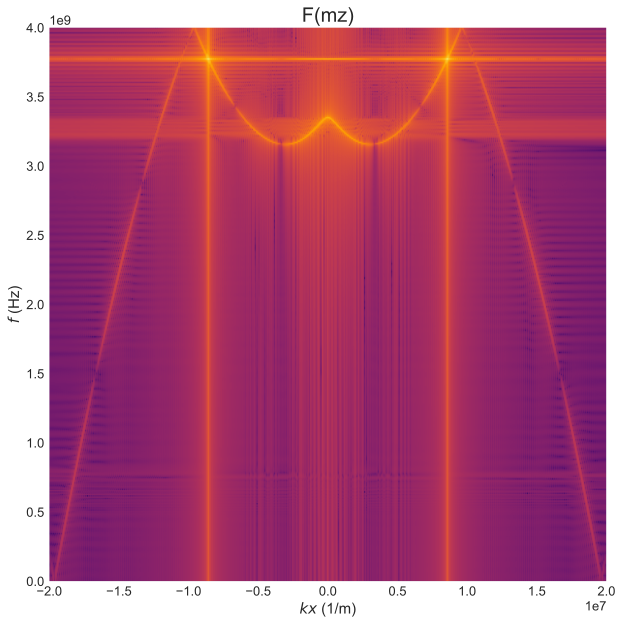

In [9]:
xbounds=(-1/(5*cx),1/(5*cx))
ybounds=(0,f_MAX)
plotDispersion(m_fft_x,xbounds,ybounds,'x')
plotDispersion(m_fft_y,xbounds,ybounds,'y')

plotDispersion(m_fft_z,xbounds,ybounds,'z')

### Time evolution

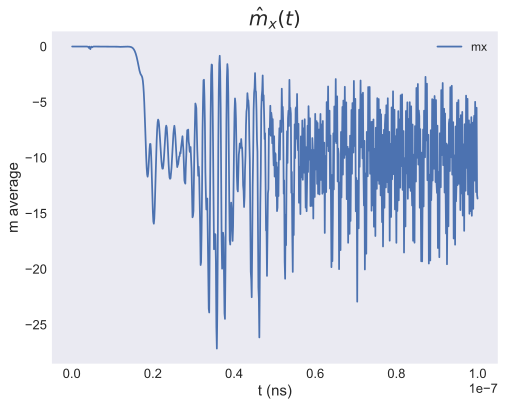

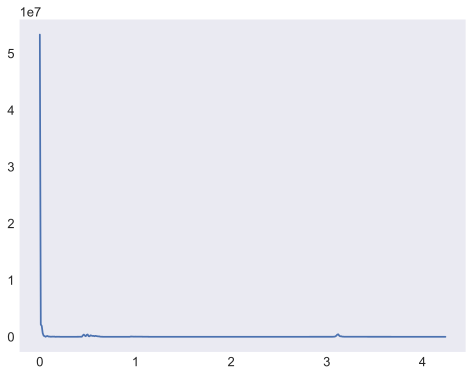

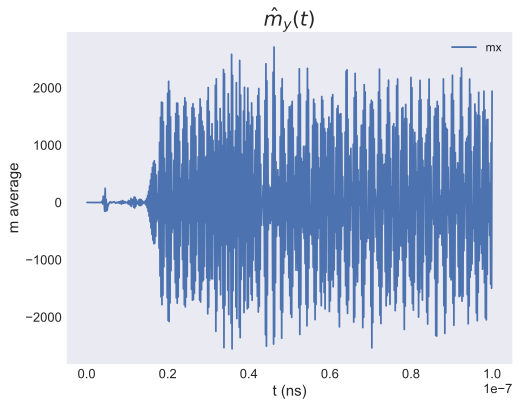

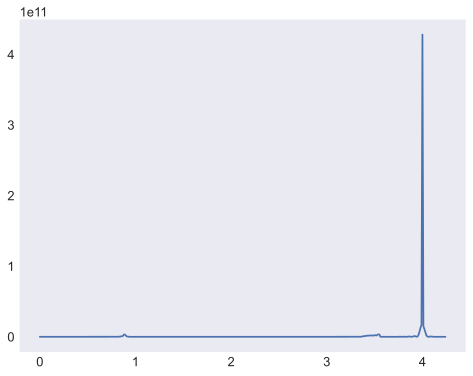

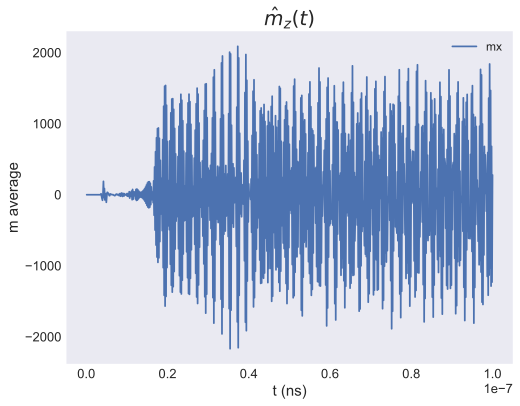

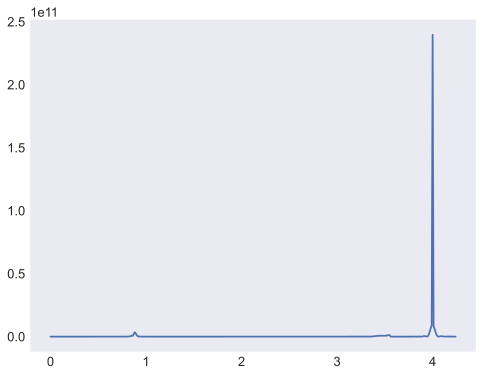

In [13]:
pos=[3/8 * l/cx,w/2/cy, 0]
getTimeEvol(timeSimData,pos,"x")
getTimeEvol(timeSimData,pos,"y")
getTimeEvol(timeSimData,pos,"z")

### Space Evolution

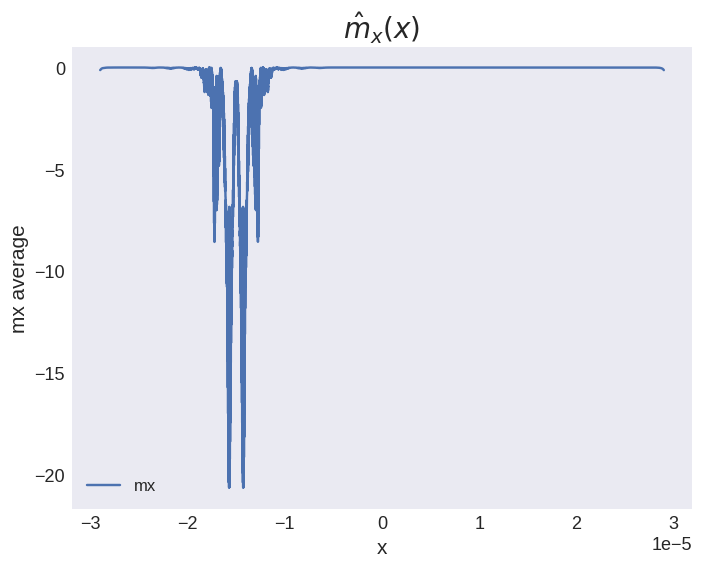

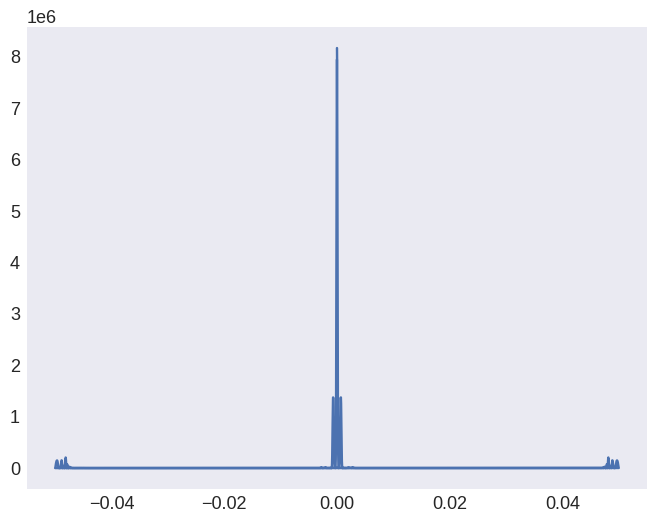

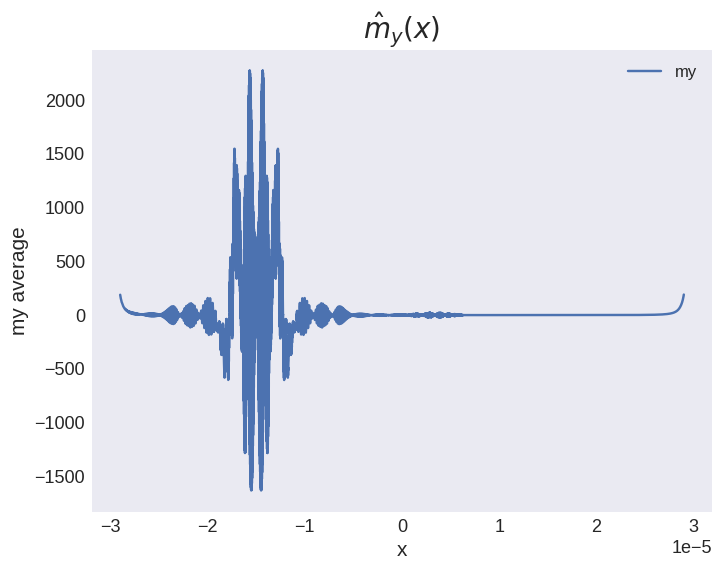

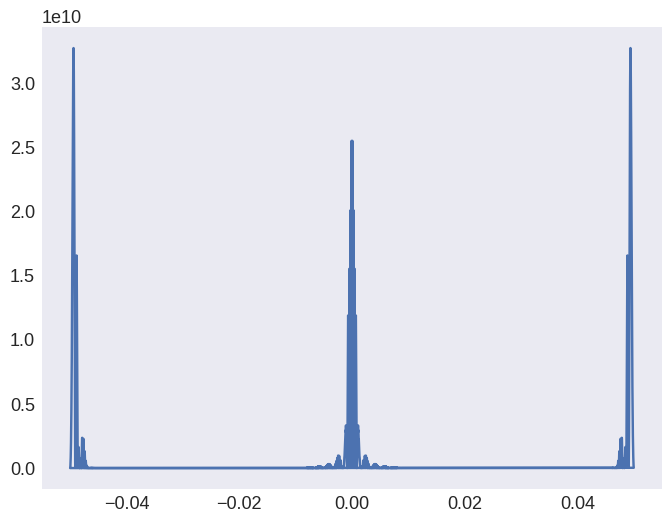

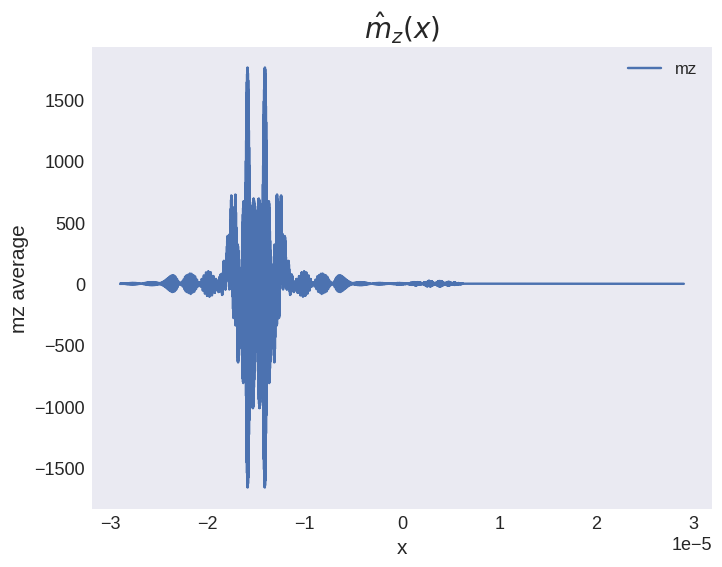

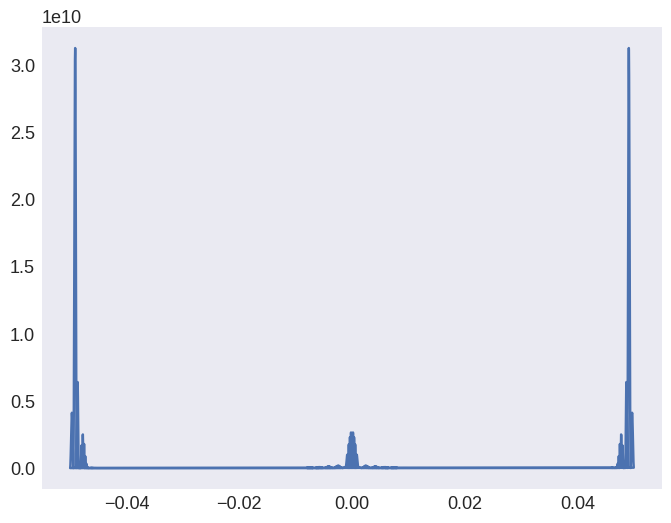

In [ ]:
getSpaceEvol(timeSimData,band,l-band,"x")
getSpaceEvol(timeSimData,band,l-band,"y")
getSpaceEvol(timeSimData,band,l-band,"z")